In [30]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [31]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [32]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [33]:
df = pd.read_csv(INPUT_FILE)

In [34]:
sl = df.loc[df.country_name=='Swaziland']

In [35]:
sl.shape

(23784, 40)

In [36]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [37]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [38]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [39]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [23]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
print('model fit for inner CV for Sierra Leone')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Sierra Leone
Shape of input params=  (14270, 14)
Best searched parameters on inner CV {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 2500}
Best grid score on inner CV 0.980939032936
Accuracy for inner nested_cv model : 0.9802
AUC Score (test) for inner_nested cv_model: 0.994809
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=302, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [106]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
#print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Accuracy for outer nested_cv model on training data: 0.9994
AUC Score (Train) for outer nested_cv model: 0.999999
AUC Score (Test) for outer nested_cv model: 0.995923
AUC Score (Holdout) for outer nested_cv model: 0.996857
Accuracy for outer nested_cv model on holdout data: 0.9819


In [12]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
#print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Accuracy for outer nested_cv model on training data: 0.9994
AUC Score (Train) for outer nested_cv model: 0.999999
AUC Score (Test) for outer nested_cv model: 0.995923
AUC Score (Holdout) for outer nested_cv model: 0.996857
Accuracy for outer nested_cv model on holdout data: 0.9819


In [26]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [75]:
X2.shape

(23784, 14)

In [27]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.99849282  0.99746146  0.99824737  0.9956875   0.99755358]
Accuracy full-data : 0.9826
AUC Score full-data: 0.997456


(array([ 1.,  1.,  1., ...,  0.,  1.,  0.]),
 array([[  1.44528151e-02,   9.85547185e-01],
        [  1.29987001e-02,   9.87001300e-01],
        [  1.32708549e-02,   9.86729145e-01],
        ..., 
        [  9.99951780e-01,   4.81990282e-05],
        [  2.40237176e-01,   7.59762824e-01],
        [  9.62042987e-01,   3.79570089e-02]], dtype=float32))

In [28]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [48]:
save_model(model_outer, "Swazilan Holdout using TVH")

saved as Swazilan Holdout using TVH_pickle.sav


In [44]:
model_outer=pickle.load(open('Swazilan Holdout using TVH_pickle.sav', 'rb'))

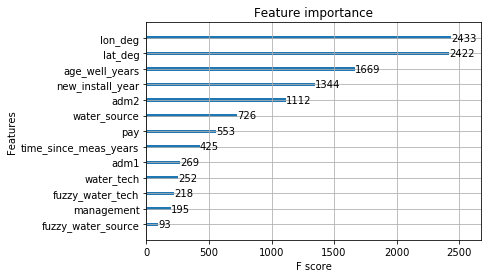

In [30]:
xgb.plot_importance(model_outer)

In [45]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if 
    return np.array(imp)

In [ ]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

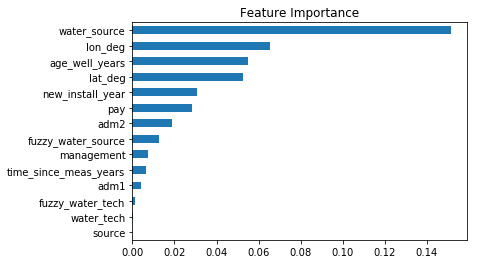

In [68]:
df = pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0)
#df.rename_axis('feature importance', axis='columns')
df.rename(columns={0:'Feature Importance'},inplace=True)
df.sort_values(by='Feature Importance').plot(kind='barh', title='Feature Importance', legend=None)

In [82]:
def plot_perm_importance(perm_importance, X_test):
    #takes a permutatino importance and the input data from it and plots
    df = pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0)
    df.rename(columns={0:'Feature Importance'},inplace=True)
    df.sort_values(by='Feature Importance').plot(kind='barh', 
                    title='Feature Importance', legend=None)

In [1]:
plot_perm_importance(imp,X_test)
savefig('foo.png', bbox_inches='tight')

NameError: name 'plot_perm_importance' is not defined

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

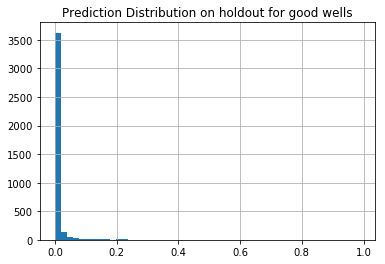

In [31]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


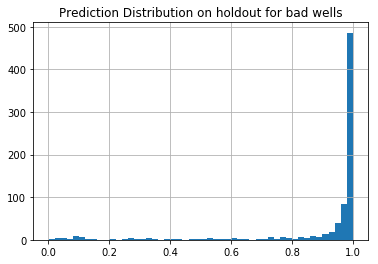

In [50]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([  0.21013227,   0.26266533,   0.21013227,   0.4727976 ,
          0.3151984 ,   0.10506613,   0.        ,   0.        ,
          0.05253307,   0.05253307,   0.1575992 ,   0.21013227,
          0.10506613,   0.21013227,   0.05253307,   0.10506613,
          0.05253307,   0.10506613,   0.05253307,   0.05253307,
          0.1575992 ,   0.26266533,   0.10506613,   0.05253307,
          0.36773147,   0.05253307,   0.05253307,   0.05253307,
          0.1575992 ,   0.3151984 ,   0.26266533,   0.3151984 ,
          0.10506613,   0.52533066,   0.57786373,   0.36773147,
          0.89306213,   1.52345893,   4.25517838,  26.89693002]),
 array([ 0.0013967 ,  0.0263451 ,  0.0512935 ,  0.0762419 ,  0.1011903 ,
         0.1261387 ,  0.1510871 ,  0.1760355 ,  0.2009839 ,  0.22593231,
         0.25088071,  0.27582911,  0.30077751,  0.32572591,  0.35067431,
         0.37562271,  0.40057111,  0.42551951,  0.45046791,  0.47541631,
         0.50036471,  0.52531311,  0.55026151,  0.57520991,  0.600

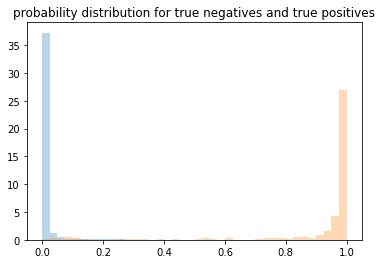

In [33]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### This is a much better spread than our small holdout last time. I wonder if this is from the target leakage from the repeat measurements? Could that even be target leakage?

In [34]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dtest_predprob > i, 1,0)
    recall = metrics.recall_score(y_test, test)
    precision = metrics.precision_score(y_test, test)
    f_score = metrics.f1_score(y_test, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame

,recall,precision,f1_score
0.000000,1.000000,0.160395,0.276449
0.026316,0.993447,0.713748,0.830685
0.052632,0.985583,0.794926,0.880047
0.078947,0.977720,0.829811,0.897714
0.105263,0.971166,0.852704,0.908088
0.131579,0.967235,0.867215,0.914498
0.157895,0.963303,0.880240,0.919900
0.184211,0.955439,0.887942,0.920455
0.210526,0.950197,0.902864,0.925926
0.236842,0.947575,0.908291,0.927518


In [52]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dholdout_predprob > i, 1,0)
    recall = metrics.recall_score(y_holdout, test)
    precision = metrics.precision_score(y_holdout, test)
    f_score = metrics.f1_score(y_holdout, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame

,recall,precision,f1_score
0.000000,1.000000,0.160395,0.276449
0.026316,0.994758,0.708683,0.827699
0.052632,0.988204,0.792850,0.879813
0.078947,0.982962,0.833333,0.901984
0.105263,0.969856,0.854503,0.908533
0.131579,0.963303,0.875000,0.917031
0.157895,0.960682,0.890644,0.924338
0.184211,0.960682,0.899387,0.929024
0.210526,0.959371,0.911582,0.934866
0.236842,0.959371,0.919598,0.939064


In [40]:
model_outer=pickle.load(open('Swazilan Holdout using TVH_pickle.sav', 'rb'))

## Modeling Decision: Threshold of 0.21056 gives a recall > 0.95 and a precision > 0.9 on both test and holdout. Will use as threshold

### Create predictions for the out years based on data. Need to update our time since measurement for X_today. 

In [42]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
301738,4,14,0,0,3,22,27,-27.1031,31.1317,17,36.2,2.7,0,3


In [43]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4


In [45]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today[['age_well_years', 'time_since_meas_years']][:1])
print(X_1year[['age_well_years', 'time_since_meas_years']][:1])
print(X_3year[['age_well_years', 'time_since_meas_years']][:1])
print(X_5year[['age_well_years', 'time_since_meas_years']][:1])

        age_well_years  time_since_meas_years
301738            33.5                    2.7
        age_well_years  time_since_meas_years
301738            36.2                    2.7
        age_well_years  time_since_meas_years
301738            37.2                    2.7
        age_well_years  time_since_meas_years
301738            39.2                    2.7
        age_well_years  time_since_meas_years
301738            41.2                    2.7


# Get Predictions for Today, 1, 3 and 5 years out

In [46]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [47]:
# append them to the original df
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [40]:
#old way, without updated time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,23784.000000,23784.000000,23784.00000,23784.000000,23784.000000
mean,0.160360,0.144215,0.12172,0.112891,0.108981
std,0.366947,0.351315,0.32697,0.316466,0.311622
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000


In [48]:
#with corrected time to measure, however still using 0.5 threshold
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,23784.000000,23784.000000,23784.000000,23784.000000,23784.000000
mean,0.160360,0.144215,0.143668,0.145728,0.145602
std,0.366947,0.351315,0.350760,0.352841,0.352714
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# 0.5 threshold won't do, setting a modeling decision of > 90% recall for our prediction threshold

In [49]:
threshold = 0.21056
#recall > 90%, we want to catch all of the bad wells
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [54]:
#old, without updated time to measure years, but new threshold
#sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,23784.000000,23784.000000,23784.000000,23784.000000,23784.000000
mean,0.160360,0.171039,0.163303,0.112891,0.156786
std,0.366947,0.376551,0.369650,0.316466,0.363607
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
#with corrected time to measure years and updated threshold
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,23784.000000,23784.000000,23784.000000,23784.000000,23784.000000
mean,0.160360,0.144215,0.143668,0.145728,0.145602
std,0.366947,0.351315,0.350760,0.352841,0.352714
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.one_year_preds==1)].shape

(79, 48)

In [52]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      3994
        1.0       0.96      0.93      0.94       763

avg / total       0.98      0.98      0.98      4757



In [53]:
dholdout_predictions = model_outer.predict(X_holdout)
print(metrics.confusion_matrix(y_holdout, dholdout_predictions))

[[3961   33]
 [  53  710]]


In [54]:
sl.head()

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,today_preds,today_predprob,one_year_preds,one_year_predprob,three_year_preds,three_year_predprob,five_year_preds,five_year_predprob
301738,Swaziland,Borehole fitted with submersible pump,Standpipe,no,1.0,Community Management,15,__MISSING__,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472293,07/01/2015 12:00:00 AM +0000,SZ,Access Point6002,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1031,31.1317,"(-27.1031, 31.1317)",1.0,NaN,NaN,NaN,2015-07-01,1982-01-01 00:00:00,12234 days 00:00:00.000000000,12234.0,1.0,981 days 00:00:00.000000000,2.7,33.5,Borehole,Standpipe Stand Post,1.0,0.922439,1.0,0.895547,1.0,0.895547,1.0,0.884434
301739,Swaziland,Borehole fitted with submersible pump,Standpipe,no,1.0,Community Management,15,__MISSING__,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472294,07/01/2015 12:00:00 AM +0000,SZ,Access Point6004,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1045,31.1286,"(-27.1045, 31.1286)",1.0,NaN,NaN,NaN,2015-07-01,1982-01-01 00:00:00,12234 days 00:00:00.000000000,12234.0,1.0,981 days 00:00:00.000000000,2.7,33.5,Borehole,Standpipe Stand Post,1.0,0.922439,1.0,0.895547,1.0,0.895547,1.0,0.884434
301740,Swaziland,Borehole fitted with submersible pump,Standpipe,no,1.0,Community Management,15,__MISSING__,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472295,07/01/2015 12:00:00 AM +0000,SZ,Access Point6005,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1051,31.1281,"(-27.1051, 31.1281)",1.0,NaN,NaN,NaN,2015-07-01,1982-01-01 00:00:00,12234 days 00:00:00.000000000,12234.0,1.0,981 days 00:00:00.000000000,2.7,33.5,Borehole,Standpipe Stand Post,1.0,0.929609,1.0,0.904946,1.0,0.904946,1.0,0.894715
301741,Swaziland,Borehole fitted with submersible pump,Standpipe,no,1.0,Community Management,15,__MISSING__,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472296,07/01/2015 12:00:00 AM +0000,SZ,Access Point6007,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1068,31.1275,"(-27.1068, 31.1275)",1.0,NaN,NaN,NaN,2015-07-01,1982-01-01 00:00:00,12234 days 00:00:00.000000000,12234.0,1.0,981 days 00:00:00.000000000,2.7,33.5,Borehole,Standpipe Stand Post,1.0,0.923510,1.0,0.896948,1.0,0.896948,1.0,0.885965
301742,Swaziland,Borehole fitted with submersible pump,Standpipe,no,1.0,Community Management,15,__MISSING__,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472297,07/01/2015 12:00:00 AM +0000,SZ,Access Point6008,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1096,31.1319,"(-27.1096, 31.1319)",1.0,NaN,NaN,NaN,2015-07-01,1982-01-01 00:00:00,12234 days 00:00:00.000000000,12234.0,1.0,981 days 00:00:00.000000000,2.7,33.5,Borehole,Standpipe Stand Post,1.0,0.914814,1.0,0.885606,1.0,0.885606,1.0,0

In [60]:
sl.to_csv('Swaziland_w_outyear_predictions.csv')

In [87]:
df=pd.read_csv('Swaziland_w_outyear_predictions.csv')

# Summarize for write up

In [42]:
gp = df.groupby(['fuzzy_water_source', 'fuzzy_water_tech', 'status_binary']).size().unstack()
gp['percentage_broken'] = round(gp[1]/gp.sum(axis=1)*100,2)
gp.reset_index(inplace=True)
gp.rename(columns={0:'# functioning', 1:'# not functioning'},index={'status_binary':'index'},  inplace=True)
gp.rename_axis('index', axis='columns').fillna(0)
#gp.drop(columns=gp.status_binary, axis=1)
#gp.rename(index=str)


index,fuzzy_water_source,fuzzy_water_tech,# functioning,# not functioning,percentage_broken
0,Borehole,Borehole,990.0,472.0,32.28
1,Borehole,Spring River Stream Protected,4.0,3.0,42.86
2,Borehole,Standpipe Stand Post,6643.0,2330.0,25.97
3,Borehole,no match,637.0,228.0,26.36
4,Hand Pump,Borehole,1.0,0.0,0.00
5,Hand Pump,Lake Pond Dam,4.0,1.0,20.00
6,Hand Pump,Standpipe Stand Post,102.0,0.0,0.00
7,Hand Pump,no match,19.0,0.0,0.00
8,Spring River Stream Protected,Borehole,4.0,0.0,0.00
9,Spring River Stream Protected,Lake Pond Dam,4.0,0.0,0.00


# Examine the age of the wells by tech, source

[None, None, None, None, None, None]

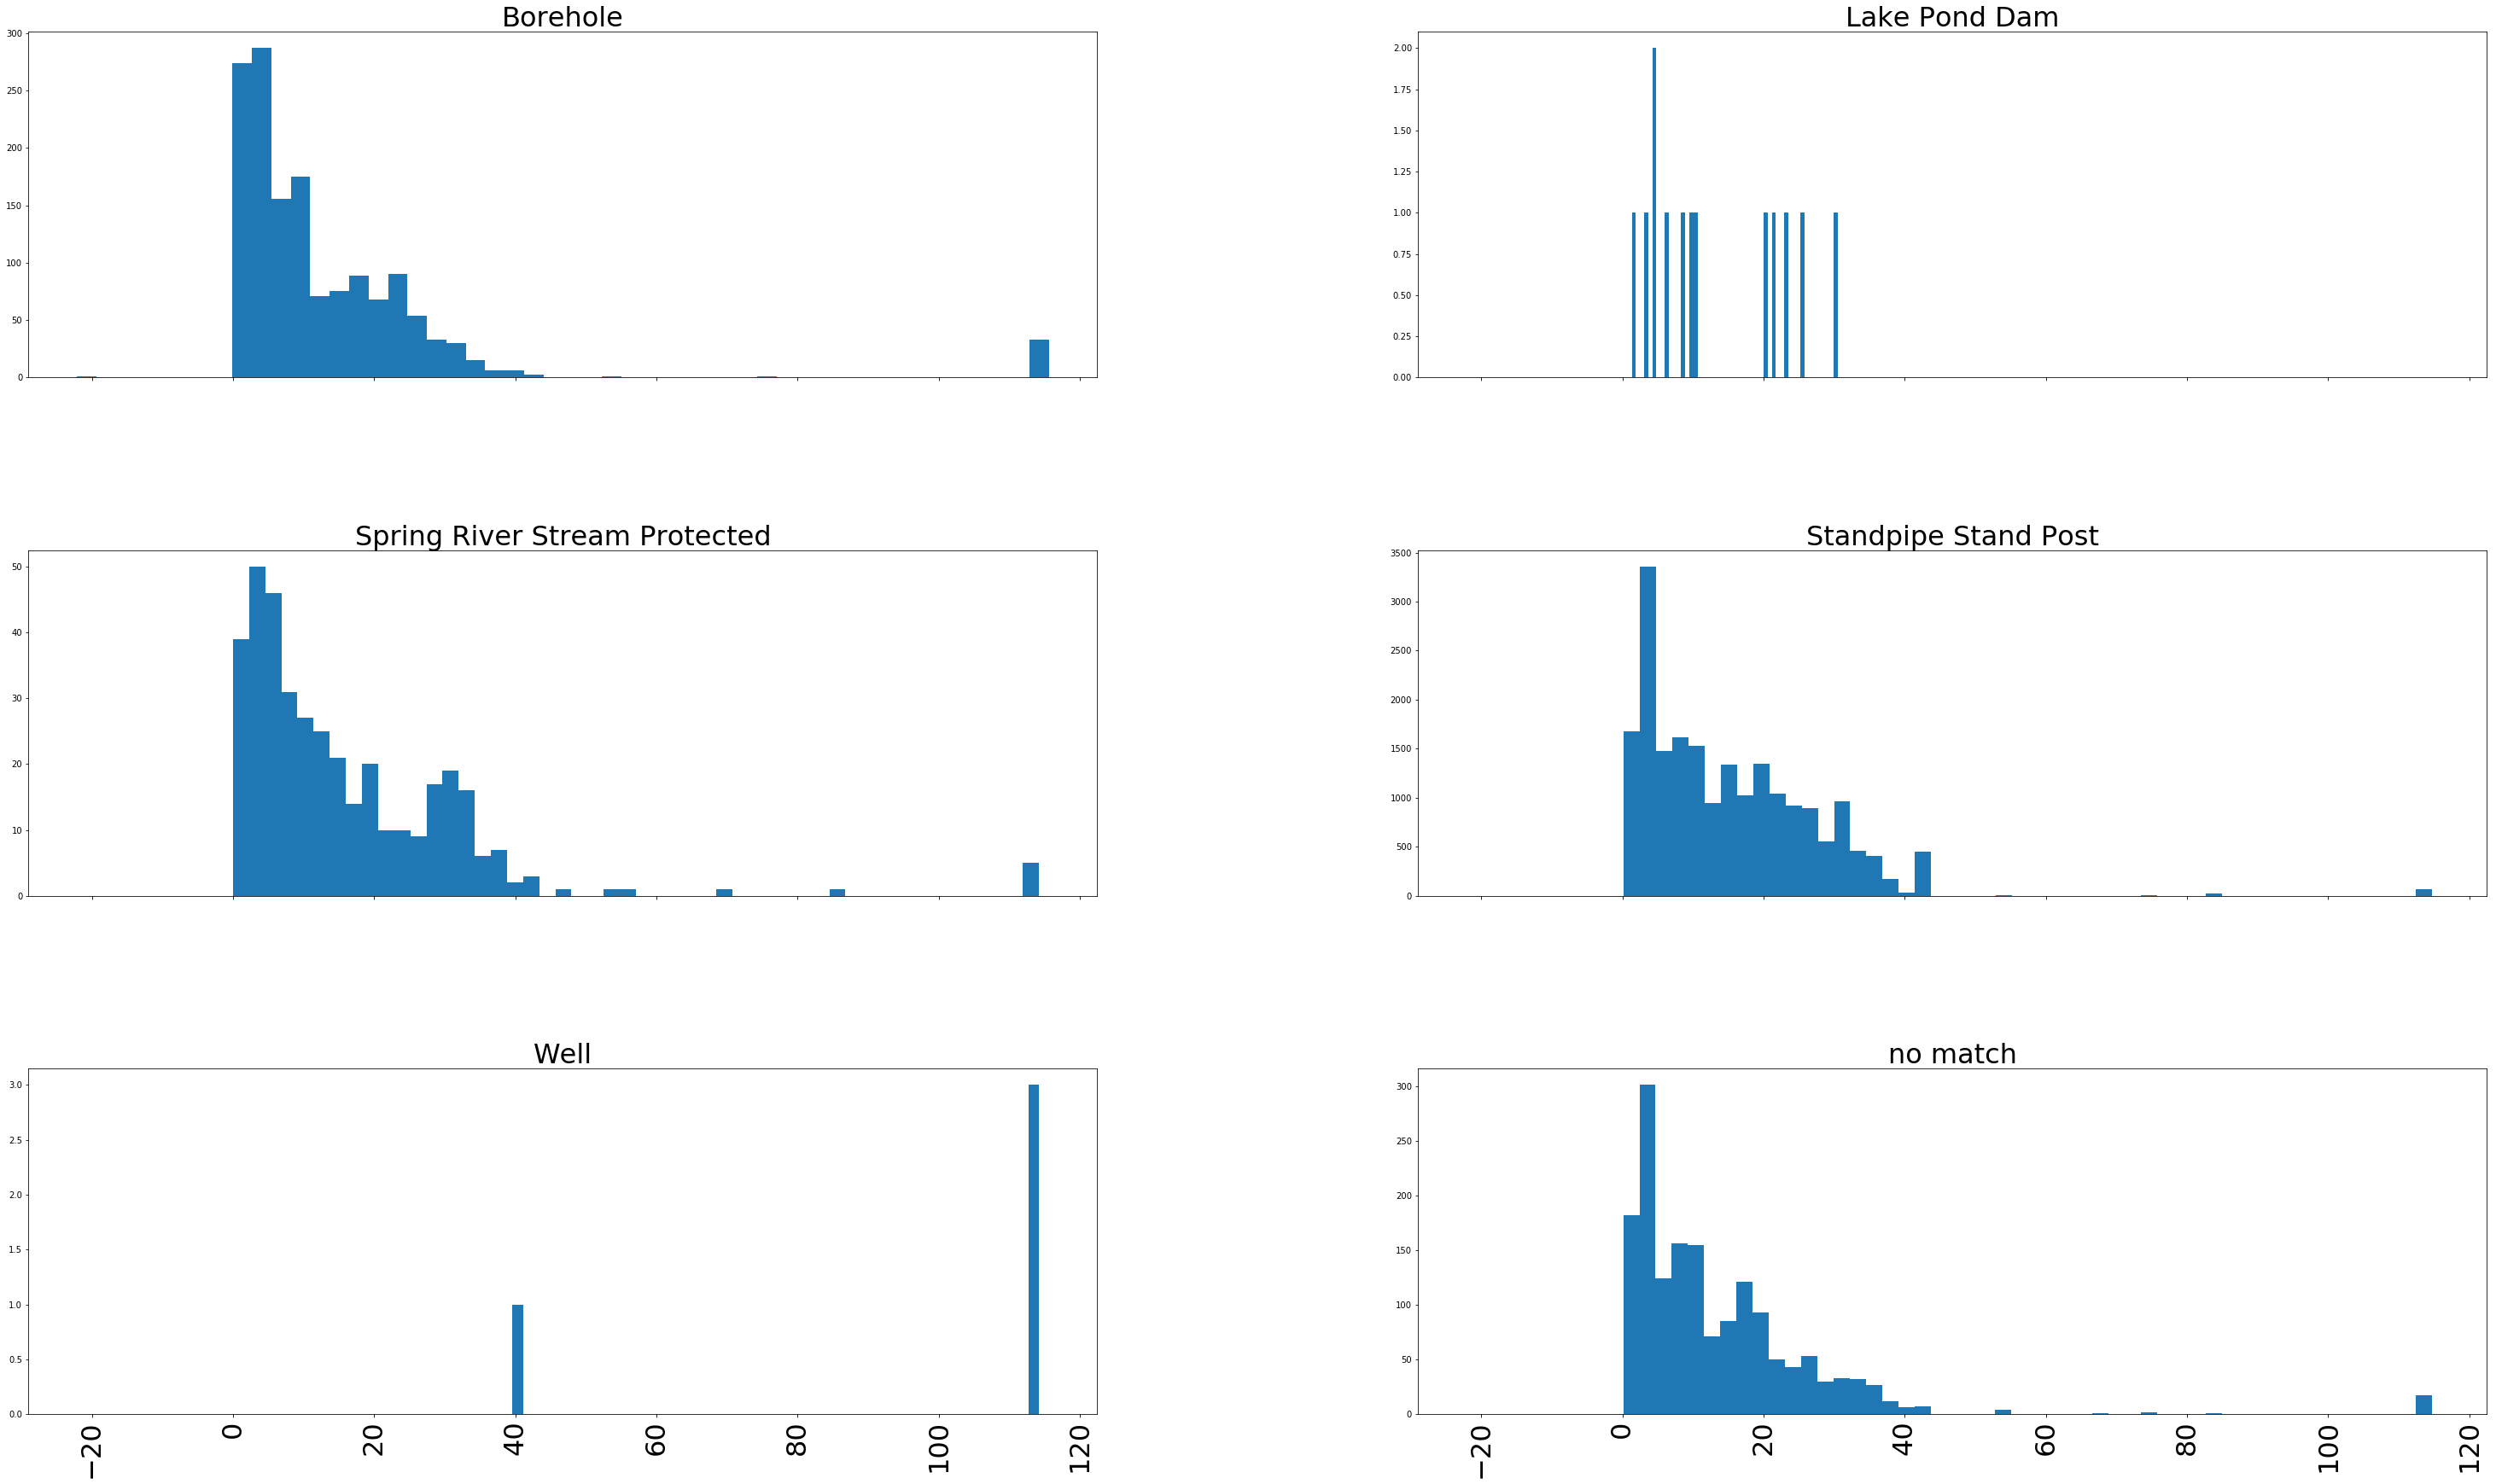

In [80]:
plt.rcParams['xtick.labelsize'] = 32
#exclude missing values for well age - 274
fig = sl[sl.age_well_years!=274].hist('age_well_years', by='fuzzy_water_tech', bins=50, figsize=(50,30), sharex=True)
[x.title.set_size(32) for x in fig.ravel()]


[None, None, None, None, None, None]

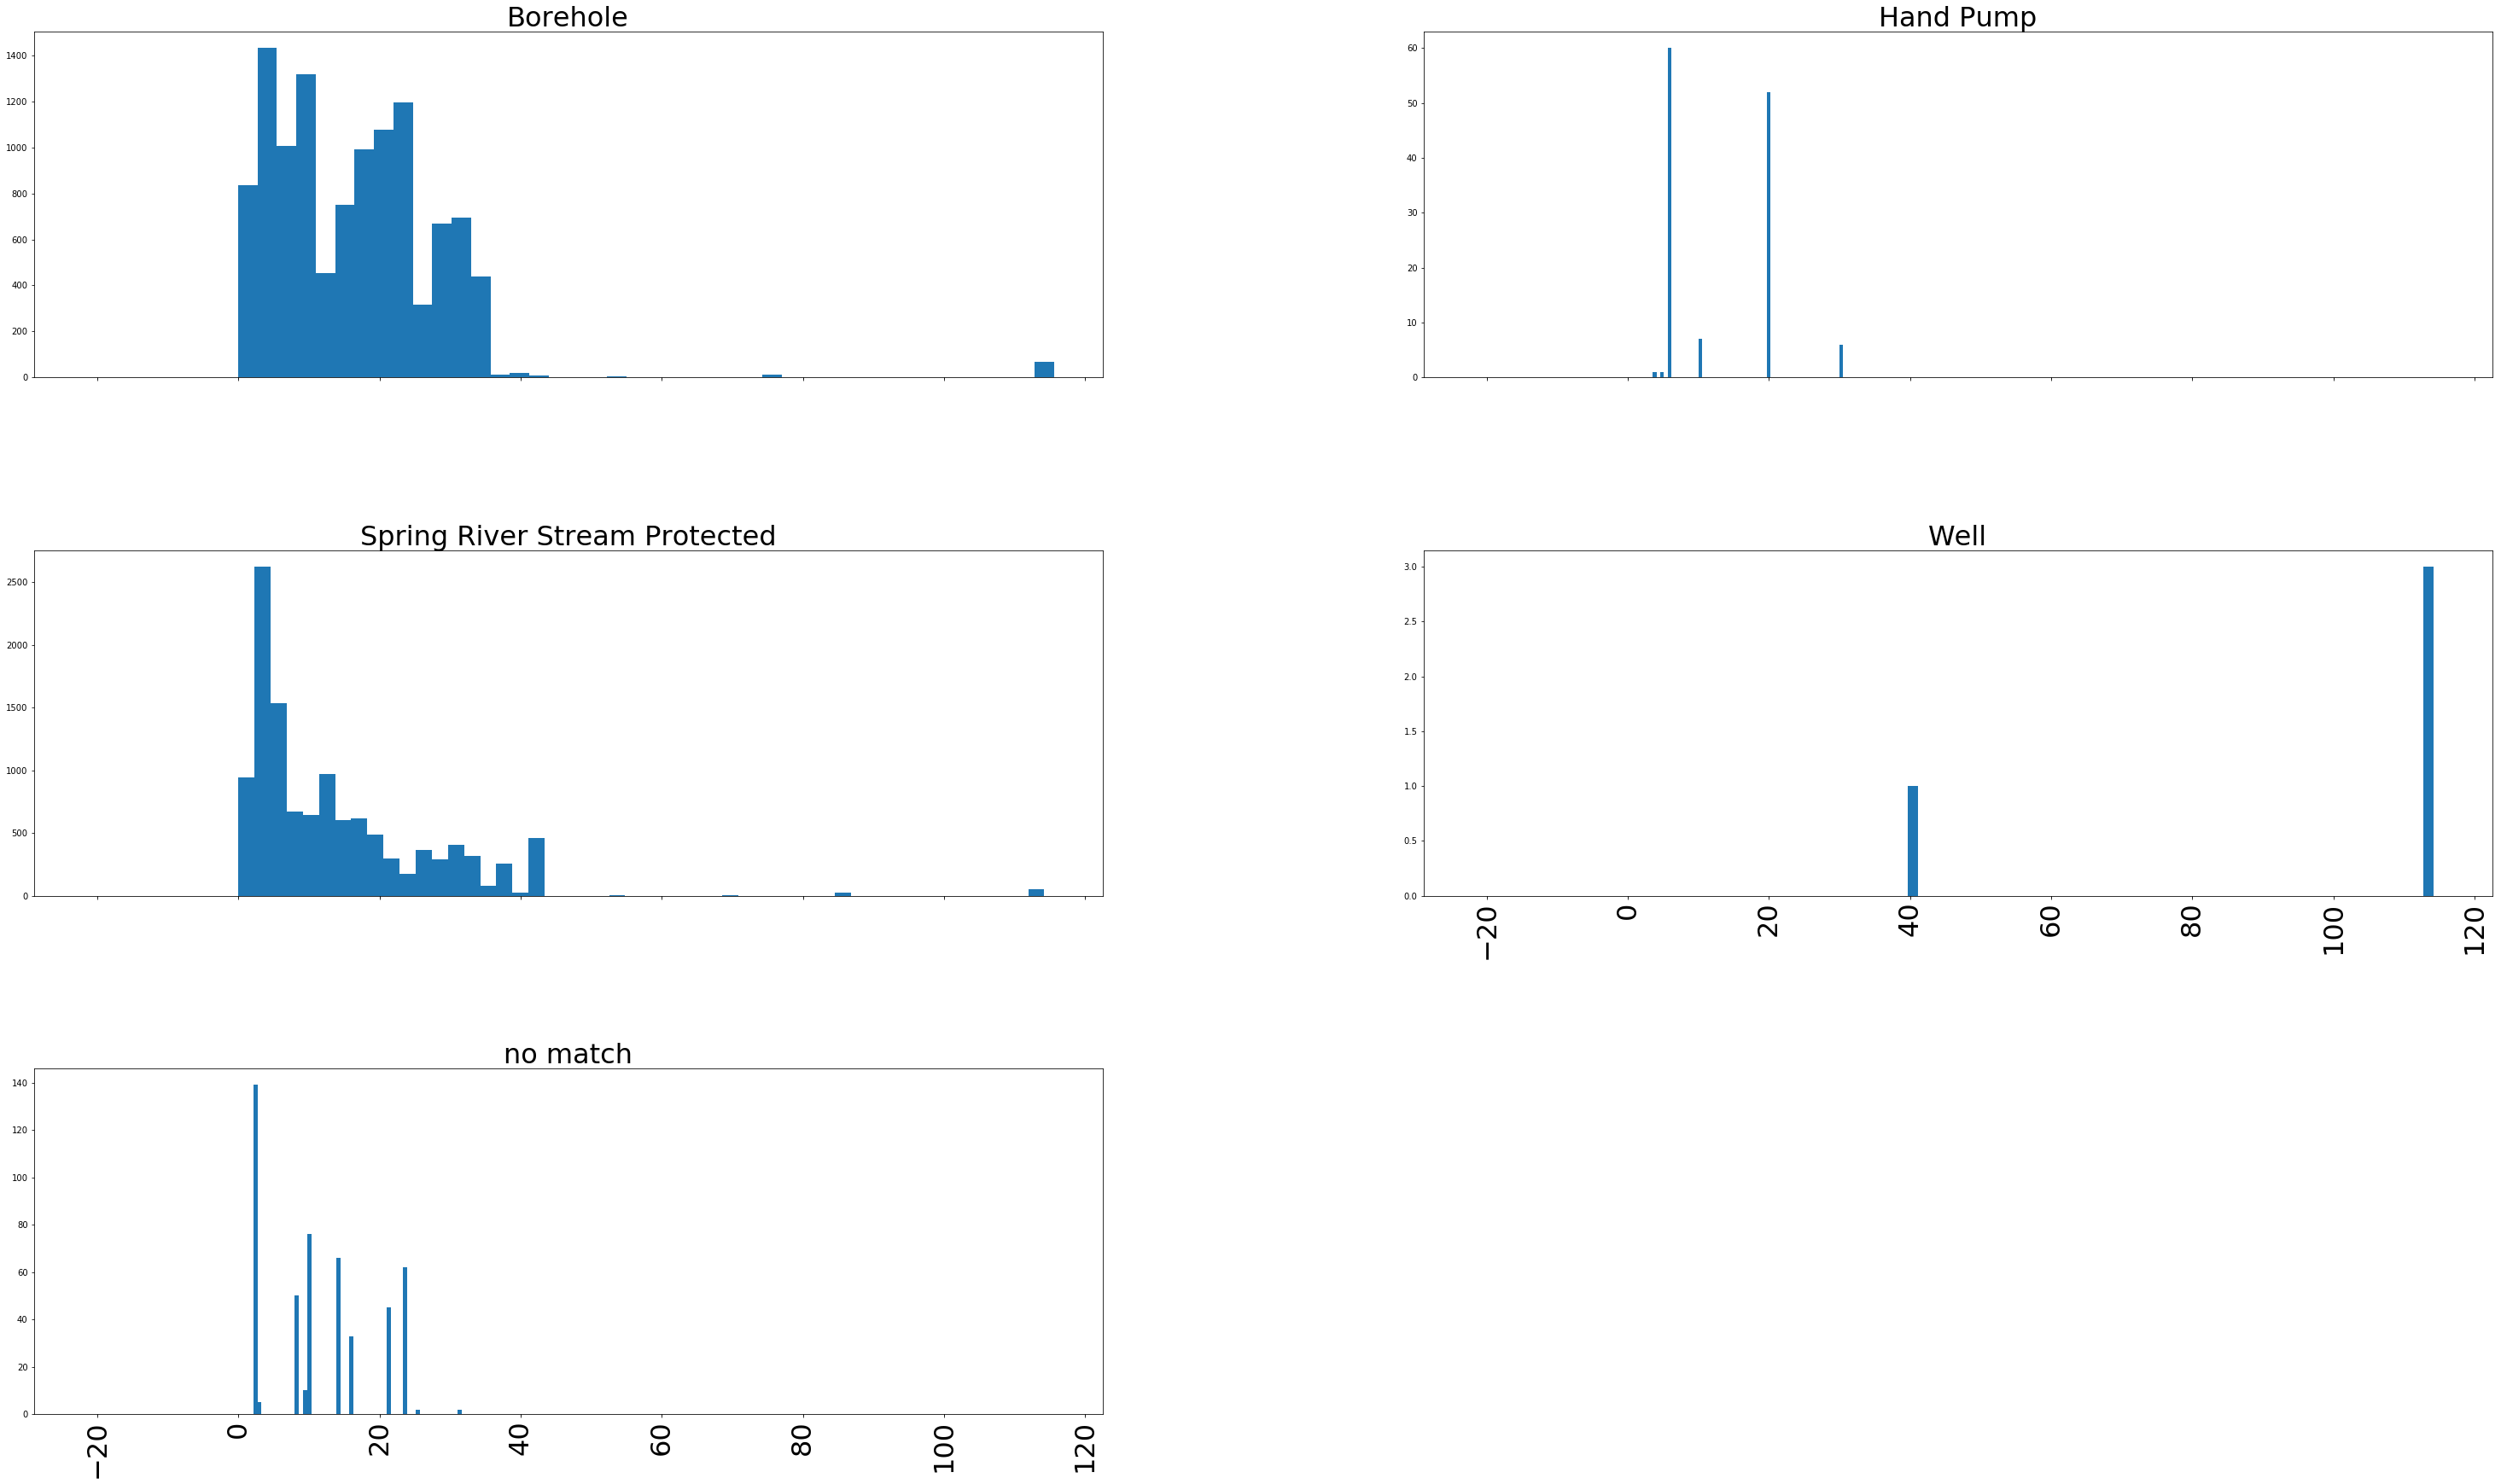

In [79]:
plt.rcParams['xtick.labelsize'] = 32
fig = sl[sl.age_well_years!=274].hist('age_well_years', by='fuzzy_water_source', bins=50, figsize=(50,30), sharex=True)
[x.title.set_size(32) for x in fig.ravel()]


# Ensure that if a point was ever bad in the past, it will show as bad in all points in the future

In [55]:
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [113]:
#old, without updated time to measure years
coerced = append_outyear_predictions(sl, 0.21056, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [116]:
#old, without updated time to measure years
coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,23784.000000,23784.000000,23784.000000,23784.000000,23784.000000
mean,0.160360,0.176757,0.182139,0.184452,0.186134
std,0.366947,0.381471,0.385967,0.387860,0.389223
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [117]:
coerced.to_csv('Swaziland_w_outyear_predictions_coerced.csv')

In [118]:
print(coerced[coerced.status_binary==0][(coerced.today_preds<coerced.three_year_preds)].shape)

(183, 48)


In [56]:
#with corrected time to measure years
coerced2 = append_outyear_predictions(sl, 0.21056, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [57]:
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,23784.000000,23784.000000,23784.000000,23784.000000,23784.000000
mean,0.160360,0.176757,0.180962,0.186638,0.191137
std,0.366947,0.381471,0.384995,0.389629,0.393205
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
coerced2.to_csv('Swaziland_w_outyear_predictions_coerced_correct_time2.csv')